<a href="https://colab.research.google.com/github/nishantkapps/aiml-projects/blob/main/capstone_food101_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<li> Unzip images into respective folders in google drive
<li> Review counts of images per class<br>
&emsp; &emsp; <i>This should be around 1000 images per class</i>
<li> Resize all images to 224 X 224 (as it is supported by pretrained algos)
<li> <font color='green'><b>Manual</b></font> : Select 50 images from each class
<li> <font color='green'><b>Manual</b></font> : Annotate the images using Makesense tool <br>
&emsp;&emsp;<i>Each image should have only one rectangular bounding box</i>
<li> <font color='green'><b>Manual</b></font> : Upload the annotation file (.csv) to each class folder
<li> Convert all images to RGB format for consistency
<li> Read images from the directory and print a few images
<li> Check if all images are of size 224 X 224
<li> Build a basic CNN model
<li> Split the images into train & test ( 70:30 )
<li> Train the CNN model
<li> Check for accuracy of prediction
<li> Print a few images from test (unseen) & predicted class

## Section 1 : Preprocessing Images & Reading Data for basic CNN

In [56]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv2
import os, sys
import glob
from os import listdir
from os.path import isfile, join
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.utils import to_categorical

In [ ]:
"""
with zipfile.ZipFile("/content/drive/MyDrive/datasets/cs/Food_101.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/datasets/cs/Food_101/")
"""

'\nwith zipfile.ZipFile("/content/drive/MyDrive/datasets/cs/Food_101.zip","r") as zip_ref:\n    zip_ref.extractall("/content/drive/MyDrive/datasets/cs/Food_101/")\n'

In [2]:
rootdir = '/content/drive/MyDrive/datasets/cs/Food_101/Food_101'
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

In [3]:
# list all folders inside train directory
def getimagesandlabels(rootdir):

  images = []
  foods = []
  filenames = []
  labels = []

  for label in os.listdir(rootdir):
    # print(label)

    if label!= '.DS_Store':
      labels.append(label)
      classpath = os.path.join(rootdir, label)
      # imagecount = 0
      # print(label, ": ", classpath)

      for image in os.listdir(classpath):
        dummy = cv2.imread(os.path.join(classpath, image))
        filenames.append(image)
        images.append(dummy)
        foods.append(label)

        # Tested with 50 images first
        # imagecount += 1
        # if imagecount == 50:
        #   break

  return images, foods, filenames, labels

In [4]:
images, foods, filenames, labels = getimagesandlabels(rootdir)

In [6]:
print(len(images))
print(len(foods))
print(len(filenames))
print(len(labels))

16257
16257
16257
17


In [7]:
print(images[9256])
print(foods[9256])
print(filenames[9256])

None
apple_pie
.DS_Store


In [8]:
del images[9256]
del foods[9256]
del filenames[9256]

In [9]:
# Find the distinct image sizes across all classes
shapes = []
sizes = []
for i in range(len(images)):
  size = images[i].shape
  shapes.append(str(size[0])+'X'+str(size[1])+'X'+str(size[2]))
  sizes.append(size)

In [10]:
np.unique(shapes)

array(['188X512X3', '222X512X3', '232X512X3', '239X512X3', '241X512X3',
       '246X512X3', '253X512X3', '268X512X3', '273X512X3', '274X512X3',
       '276X512X3', '287X512X3', '288X512X3', '289X512X3', '292X512X3',
       '294X512X3', '296X512X3', '298X512X3', '300X512X3', '301X512X3',
       '303X512X3', '304X512X3', '306X512X3', '307X512X3', '308X512X3',
       '309X512X3', '310X512X3', '313X512X3', '317X512X3', '318X512X3',
       '319X512X3', '320X512X3', '322X512X3', '324X512X3', '325X512X3',
       '326X512X3', '329X512X3', '330X512X3', '332X512X3', '333X512X3',
       '334X512X3', '335X512X3', '338X512X3', '339X512X3', '340X512X3',
       '341X512X3', '342X512X3', '343X512X3', '344X512X3', '345X512X3',
       '346X512X3', '348X512X3', '351X512X3', '352X512X3', '353X512X3',
       '355X512X3', '356X512X3', '357X512X3', '358X512X3', '359X512X3',
       '360X512X3', '362X512X3', '363X512X3', '364X512X3', '365X512X3',
       '366X512X3', '367X512X3', '368X512X3', '369X512X3', '370X

In [11]:
len(np.unique(shapes))

264

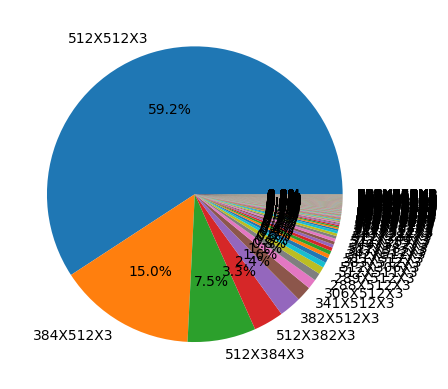

In [23]:
shp = pd.Series(shapes).value_counts(normalize=True)
plt.pie(shp, labels=shp.index, autopct='%1.1f%%')
plt.show()

In [19]:
shp[shp > 0.01]

512X512X3    0.592028
384X512X3    0.150160
512X384X3    0.074680
512X382X3    0.032849
382X512X3    0.024360
341X512X3    0.016486
306X512X3    0.010642
dtype: float64

In [24]:
df = pd.DataFrame(zip(images, foods, filenames), columns=['image', 'food', 'filename' ])

In [25]:
df['food'].value_counts()

ice_cream               1000
samosa                  1000
french_fries            1000
nachos                  1000
pizza                   1000
pancakes                1000
tacos                   1000
chocolate_cake          1000
hot_dog                 1000
spring_rolls            1000
strawberry_shortcake    1000
ravioli                 1000
falafel                 1000
waffles                 1000
donuts                  1000
onion_rings             1000
apple_pie                256
Name: food, dtype: int64

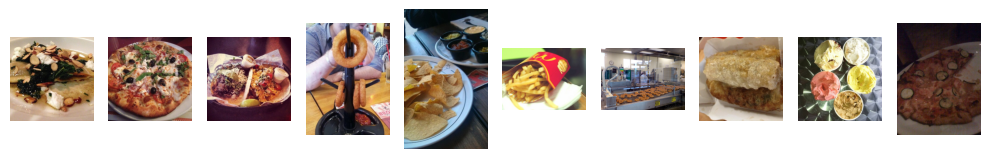

In [34]:
integer_array = np.random.randint(0, len(images)-1, 10)
fig, ax = plt.subplots(1,10, figsize=(10,10))
for i in range(len(integer_array)) :
  image_rgb = cv2.cvtColor(images[integer_array[i]], cv2.COLOR_BGR2RGB)
  ax[i].imshow(image_rgb)
  ax[i].axis('off')
plt.tight_layout()
plt.show()

In [37]:
def resize(images, filenames, foods):
  rimages = []
  rfilenames = []
  rfoods = []
  for i,img in enumerate(images):
      im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      imr = cv2.resize(im, (224, 224), interpolation=cv2.INTER_CUBIC)
      rimages.append(imr)
      rfilenames.append(filenames[i])
      rfoods.append(foods[i])
  return rimages, rfilenames, rfoods

In [38]:
rimages, rfilenames, rfoods = resize(images, filenames, foods)

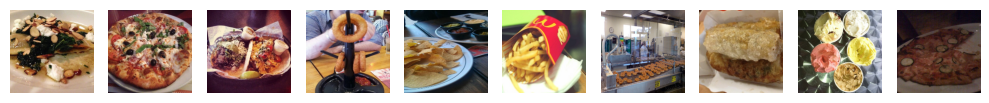

In [40]:
fig, ax = plt.subplots(1,10, figsize=(10,10))
for i in range(len(integer_array)) :
  ax[i].imshow(rimages[integer_array[i]])
  ax[i].axis('off')
plt.tight_layout()
plt.show()

In [41]:
np.savez('rdata.npz', rimages=rimages, rfilenames=rfilenames, rfoods=rfoods, labels=labels)

In [42]:
import shutil
colab_link = "/content/rdata.npz"
gdrive_link = "/content/drive/MyDrive/datasets/cs/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/datasets/cs/rdata.npz'

## Section 2 : Building the model using preprocessed data stored as npz file

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv2
import os, sys
import glob
from os import listdir
from os.path import isfile, join
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.utils import to_categorical

In [2]:
rdata = np.load('/content/drive/MyDrive/datasets/cs/rdata.npz')
rimages = rdata['rimages']
rfilenames = rdata['rfilenames']
rfoods = rdata['rfoods']
labels = rdata['labels']

In [3]:
rimages = np.asarray(rimages)
rfilenames = np.asarray(rfilenames)
rfoods = np.asarray(rfoods)

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(rimages, rfoods, test_size=0.3, random_state=42)

In [5]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(11379, 224, 224, 3)
(4877, 224, 224, 3)
(11379,)
(4877,)


In [6]:
# Normalize pixel values to be between 0 and 1
xtrnscl, xtstscl = xtrain / 255.0, xtest / 255.0

In [7]:
le = LabelEncoder()
ytrnenc = le.fit_transform(ytrain)
ytstenc = le.transform(ytest)

In [8]:
ytrncat = tf.keras.utils.to_categorical(ytrnenc, num_classes=17, dtype='int')
ytstcat = tf.keras.utils.to_categorical(ytstenc, num_classes=17, dtype='int')

In [9]:
#instantiate the model
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation="relu", input_shape=(224,224,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.Dropout(0.5))
# add flatten and dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(17, activation='softmax'))

In [10]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
history = model.fit(xtrnscl, ytrncat, epochs=20,
                    validation_data=(xtstscl, ytstcat))

Epoch 1/20
356/356 [==============================] - 19s 40ms/step - loss: 2.8749 - accuracy: 0.0650 - val_loss: 2.7612 - val_accuracy: 0.0997
Epoch 2/20
356/356 [==============================] - 7s 19ms/step - loss: 2.6982 - accuracy: 0.1210 - val_loss: 2.6552 - val_accuracy: 0.1390
Epoch 3/20
356/356 [==============================] - 7s 19ms/step - loss: 2.5885 - accuracy: 0.1692 - val_loss: 2.5568 - val_accuracy: 0.1854
Epoch 4/20
356/356 [==============================] - 7s 19ms/step - loss: 2.4877 - accuracy: 0.2076 - val_loss: 2.4742 - val_accuracy: 0.2153
Epoch 5/20
356/356 [==============================] - 7s 18ms/step - loss: 2.3764 - accuracy: 0.2477 - val_loss: 2.3740 - val_accuracy: 0.2514
Epoch 6/20
356/356 [==============================] - 7s 18ms/step - loss: 2.2289 - accuracy: 0.2972 - val_loss: 2.3955 - val_accuracy: 0.2428
Epoch 7/20
356/356 [==============================] - 7s 18ms/step - loss: 2.0420 - accuracy: 0.3522 - val_loss: 2.3758 - val_accuracy: 0.264

In [18]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


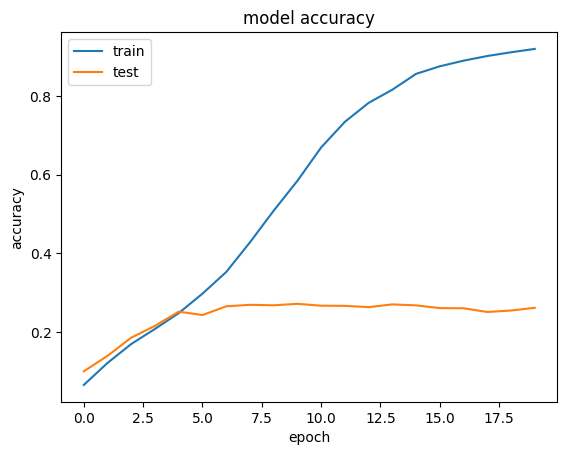

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

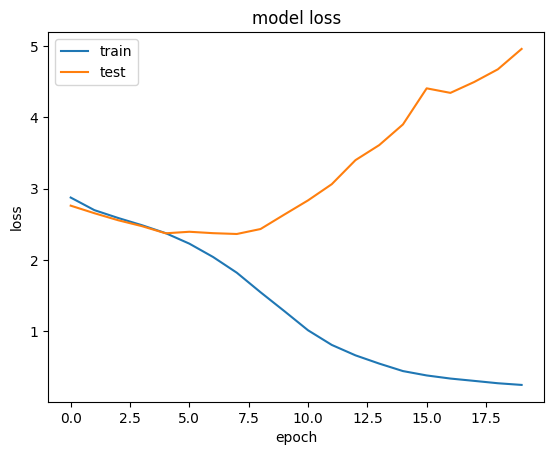

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()